In [97]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [99]:
import json
import re
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import nltk
from nltk.corpus import stopwords
import string
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add


In [100]:
captions = readTextFile("../Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]
print(len(captions))

40460


In [101]:
descriptions = {}
for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    descriptions[img_name].append(second)

In [102]:
IMG_PATH = "../Flickr_Data/Images/"


In [103]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [105]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [106]:
with open("descriptions.txt", "w") as f:
    f.write(str(descriptions))

In [107]:
descriptions = None
with open("descriptions.txt",'r') as f:
    descriptions = f.read()
json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)
print(type(descriptions))

<class 'dict'>


In [108]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print(len(vocab))

8424


In [109]:
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print(len(total_words))

373837


In [110]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [111]:
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]
print(len(total_words))

1845


In [112]:
train_file_data = readTextFile("../Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("../Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [113]:
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [114]:
model = ResNet50(weights="imagenet", input_shape=(224, 224, 3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [115]:
new_model = Model(model.input, model.layers[-2].output)

In [116]:
def preprocess_img(img):
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img
       

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


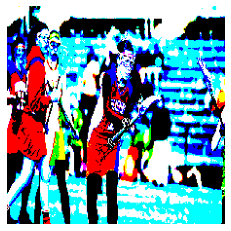

In [117]:
img = preprocess_img(IMG_PATH+"123997871_6a9ca987b1.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [118]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = new_model.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [119]:
start = time()
encoding_train = {}
for ix, img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    if ix%100==0:
        print("Encoding... ",ix) 
    end_time = time()
print(end_time-start, "secs")

Encoding...  0
Encoding...  100
Encoding...  200
Encoding...  300
Encoding...  400
Encoding...  500
Encoding...  600
Encoding...  700
Encoding...  800
Encoding...  900
Encoding...  1000
Encoding...  1100
Encoding...  1200
Encoding...  1300
Encoding...  1400
Encoding...  1500
Encoding...  1600
Encoding...  1700
Encoding...  1800
Encoding...  1900
Encoding...  2000
Encoding...  2100
Encoding...  2200
Encoding...  2300
Encoding...  2400
Encoding...  2500
Encoding...  2600
Encoding...  2700
Encoding...  2800
Encoding...  2900
Encoding...  3000
Encoding...  3100
Encoding...  3200
Encoding...  3300
Encoding...  3400
Encoding...  3500
Encoding...  3600
Encoding...  3700
Encoding...  3800
Encoding...  3900
Encoding...  4000
Encoding...  4100
Encoding...  4200
Encoding...  4300
Encoding...  4400
Encoding...  4500
Encoding...  4600
Encoding...  4700
Encoding...  4800
Encoding...  4900
Encoding...  5000
Encoding...  5100
Encoding...  5200
Encoding...  5300
Encoding...  5400
Encoding...  5500
Enco

In [120]:
with open("encoded_train_features.pkl", "wb") as f:
    pickle.dump(encoding_train, f)

In [121]:
start = time()
encoding_test = {}
for ix, img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    if ix%100==0:
        print("Test Encoding... ",ix) 
    end_time = time()
print(end_time-start, "secs")

Test Encoding...  0
Test Encoding...  100
Test Encoding...  200
Test Encoding...  300
Test Encoding...  400
Test Encoding...  500
Test Encoding...  600
Test Encoding...  700
Test Encoding...  800
Test Encoding...  900
49.969547510147095 secs


In [122]:
with open("encoded_test_features.pkl", "wb") as f:
    pickle.dump(encoding_test, f)

In [123]:
word_to_idx = {}
idx_to_word = {}
for i, word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word
print(word_to_idx["dog"])
print(idx_to_word[6])

6
dog


In [124]:
print(len(idx_to_word))

idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846
idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847
vocab_size = len(word_to_idx) + 1
print(vocab_size)

1845
1848


In [125]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len, len(cap.split()))
print(max_len)

35


In [142]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):
    x1, x2, y = [],[],[]
    n=0
    while True:
        for key, desc_list in train_descriptions.items():
            n+=1
            #print(encoding_train[key])
            photo = encoding_train[key]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)
                if n==batch_size:
                    yield ([np.array(x1), np.array(x2)], np.array(y))
                    x1,x2,y = [],[],[]
                    n=0

In [129]:
key = list(train_descriptions.keys())[0]
print(encoding_train[key])

[0.34707952 0.51159173 0.08728813 ... 1.1897286  0.04043856 0.15271077]


In [130]:
f = open("../Flickr_Data/Flickr_TextData/glove.6B.50d.txt", encoding='utf8')

In [131]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:], dtype='float')
    embedding_index[word] = word_embedding

In [132]:
f.close()

In [133]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
    return matrix

In [134]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [135]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [136]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [137]:
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input_img_features, input_captions], outputs=outputs)

In [138]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_9[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_8[0][0]                    
_______________________________________________________________________________________

In [139]:
# Pre Initialize Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [140]:
model.compile(loss='categorical_crossentropy', optimizer="adam")

In [144]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_'+str(i)+'.h5')

   1/2000 [..............................] - ETA: 1s - loss: 6.9424

C:\Users\namba\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2000/2000 [==============================] - 77s 39ms/step - loss: 2.5556


In [145]:
model = load_model('./model_weights/model_19.h5')

In [147]:
def predict_caption(photo):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len,padding='post')
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #Greedy sampling
        word = idx_to_word[ypred]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

rugby game in the air


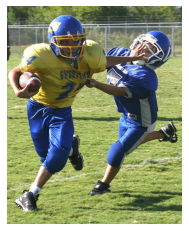

group of people are gathered in front of large building


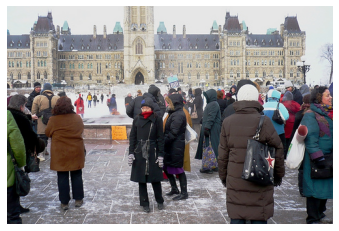

little boy in red shirt runs through the sand


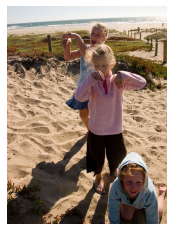

brown dog jumps over hurdle


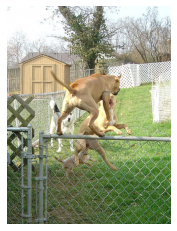

little girl in pink shirt is standing in front of some flowers


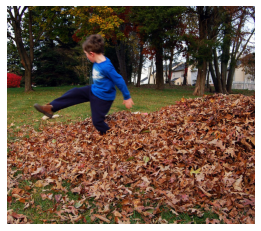

three people are standing in front of an audience


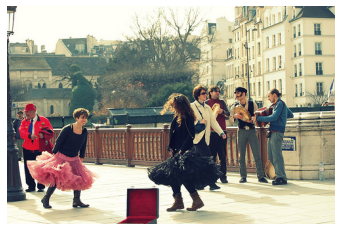

two people are jumping into the air on the beach


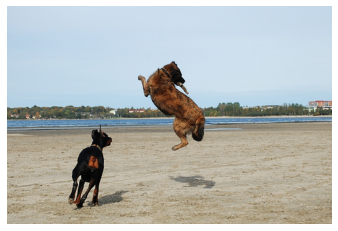

two dogs are running in the dirt


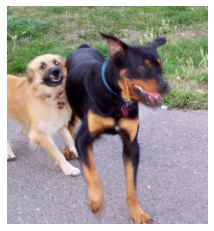

boy in red shirt and blue cap stands in the sand


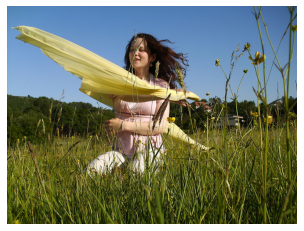

two dogs are playing with each other in the grass


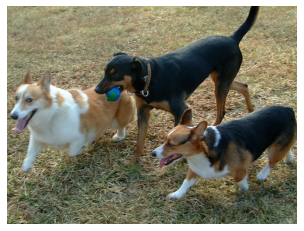

man on bicycle doing trick on his bike


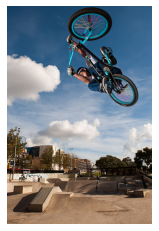

baby swinging on swing set of baby


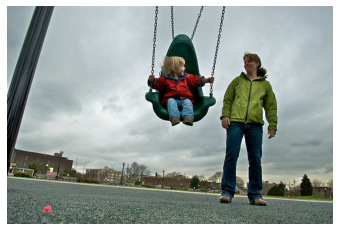

black dog running through grass


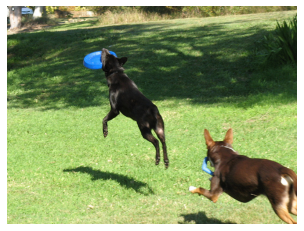

three people are sitting around table waiting


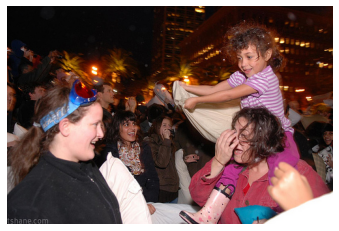

man in white shirt is rock climbing


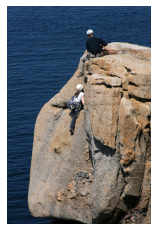

In [148]:
# Pick random images and see results
for i in range(15):
    no = np.random.randint(0,1000)
    img_name = list(encoding_test.keys())[no]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    i = plt.imread(IMG_PATH+img_name+".jpg")
    caption = predict_caption(photo_2048)
    print(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()